### Training schedules for pytorch
Learning rate schedules are mechanisms used during the training of neural networks to adjust the learning rate over time. They are designed to decrease the learning rate as the training progresses, allowing the network to make large adjustments in the initial stages of training, when the weights are likely far from their optimal values, and then make smaller adjustments as the training progresses, to fine-tune the weights. These adjustments helps mitigate the risk of overshooting the minimum point of the loss function and helps to reach convergence more smoothly.

In PyTorch, one of the learning rate scheduling tools is the StepLR class, found in the `torch.optim.lr_scheduler` module. StepLR is a type of learning rate schedule that decreases the learning rate by a certain factor every few epochs. This allows the learning rate to decrease in a step-wise fashion rather than continuously, which can be beneficial in some cases, as it gives the model time to 'settle' into ares of the loss landscape before the learning rate is reduced further.

StepLR takes three parameters:

- optimizer: the optimizer you are using to train your model
- step_size: this is the number of epochs after which you want to reduce the learning rate. For instance, if step_size=10, then the learning rate will be reduced every 10 epochs.
- gamma: this is the factor by which the learning rate will be reduced at each step. For instance, if gamma = 0.1, the learning rate will be multiplied by 0.1 at each step; this is a reduction of lr by 90%

The StepLR scheduler is used during the training loop. After each step of the optimizer (after `optimizer.step()`), you call `scheduler.step()` to adjust the learning rate according to the schedule.

It's worth nothing that the choice of step_size and gamma can be important, and may need to be tuned based on your specific problem and dataset. Too large step_size and the learning rate may not reduce quickly enough; too small and it may reduce too quickly. Similarly, a gamma too close to 1 may not reduce the learning rate significantly enough, while a gamma too small may reduce it too quickly.

### Schedule changing the lr with k-fold cross validation

In [1]:
import copy
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from scipy.stats import zscore
import matplotlib.pyplot as plt

In [2]:
# selecting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# early stopping definition
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
        
    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement found in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False


print(device)

cuda


In [3]:
# load the data adn fill NA values with the median for all fields
def fill_na_with_median(df):
    """
    Replace all na values in numeric fields with median
    """
    for col in df.columns:
        if df[col].dtype in ['float32', 'int32', 'int64', 'float64', 'long']:
            median = df[col].median()
            df[col] = df[col].fillna(median)
    return df


def load_dataset(route, fill_na=False):
    df = pd.read_csv(route, na_values=["NA", "?"])
    if fill_na:
      df = fill_na_with_median(df)
    return df


df = load_dataset("data/jh-simple-dataset.csv", fill_na=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2000 non-null   int64  
 1   job             2000 non-null   object 
 2   area            2000 non-null   object 
 3   income          2000 non-null   float64
 4   aspect          2000 non-null   float64
 5   subscriptions   2000 non-null   int64  
 6   dist_healthy    2000 non-null   float64
 7   save_rate       2000 non-null   int64  
 8   dist_unhealthy  2000 non-null   float64
 9   age             2000 non-null   int64  
 10  pop_dense       2000 non-null   float64
 11  retail_dense    2000 non-null   float64
 12  crime           2000 non-null   float64
 13  product         2000 non-null   object 
dtypes: float64(7), int64(4), object(3)
memory usage: 218.9+ KB


In [4]:
# generate dummies
def generate_dummies(df, dummies_list, drop_original=True):
    """Generate dummies for certain categorical columns"""
    for col in dummies_list:
        if df[col].dtype in ['object', 'categories']:
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col, dtype=int)], axis=1)
            if drop_original:
                df.drop(col, axis=1, inplace=True)

    return df

df = generate_dummies(df, ["job", "area", "product"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 55 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2000 non-null   int64  
 1   income          2000 non-null   float64
 2   aspect          2000 non-null   float64
 3   subscriptions   2000 non-null   int64  
 4   dist_healthy    2000 non-null   float64
 5   save_rate       2000 non-null   int64  
 6   dist_unhealthy  2000 non-null   float64
 7   age             2000 non-null   int64  
 8   pop_dense       2000 non-null   float64
 9   retail_dense    2000 non-null   float64
 10  crime           2000 non-null   float64
 11  job_11          2000 non-null   int32  
 12  job_al          2000 non-null   int32  
 13  job_am          2000 non-null   int32  
 14  job_ax          2000 non-null   int32  
 15  job_bf          2000 non-null   int32  
 16  job_by          2000 non-null   int32  
 17  job_cv          2000 non-null   i

In [5]:
# standardize ranges
num_fields = ['income', 'aspect', 'save_rate', 'subscriptions']
for field in num_fields:
    df[field] = zscore(df[field])

### Model for regression task

In [13]:
# random torch
torch.manual_seed(42)

# features dataset (x)
x_columns = df.columns.drop(['age', 'id'])
x = torch.tensor(df[x_columns].values, device=device, dtype=torch.float32)

# labels dataset (y)
y = torch.tensor(df[['age']].values, device=device, dtype=torch.float32)

# cross validate
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# early stopping parameters
patience = 10

# Lists to store training and validation losses
train_losses_all_folds = []
val_losses_all_folds = []

# folds loop
epochs = 500
fold = 0
for train_index, test_index in kf.split(x):
    fold += 1
    print(f"Fold {fold}")
    
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # pytorch dataloader
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # create the model and optimizer
    model = nn.Sequential(
        nn.Linear(x.shape[1], 20),
        nn.ReLU(),
        nn.Linear(20, 10),
        nn.ReLU(),
        nn.Linear(10, 1),
    ).to(device)
    
    # optimizer instance
    optimizer = optim.Adam(model.parameters())
    
    # adjust learning rate every 50 epochs
    scheduler = StepLR(optimizer, step_size=50, gamma=0.90)
    loss_fn = nn.MSELoss()
    
    # early stop instance
    early_stopping = EarlyStopping(patience=patience)
    
    # training loop
    train_losses = []
    val_losses = []
    epoch = 0
    done = False
    
    while not done and epoch<epochs:
        epoch += 1
        model.train()
        batch_losses = []
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        train_loss = sum(batch_losses)/len(batch_losses)
        train_losses.append(train_loss)
        
        # validation
        model.eval()
        with torch.no_grad():
            val_output = model(x_test)
            val_loss = loss_fn(val_output, y_test)
        val_losses.append(val_loss.item())
            
        # apply learning rate schedule 
        scheduler.step() 
            
        if early_stopping(model, val_loss):
            done = True
            
    print(f"Fold {fold}, Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, {early_stopping.status}")

    train_losses_all_folds.append(train_losses)
    val_losses_all_folds.append(val_losses)

Fold 1
Fold 1, Epoch 356/500, Train Loss: 0.3116, Val Loss: 0.4200, Early stopping triggered after 10 epochs
Fold 2
Fold 2, Epoch 231/500, Train Loss: 0.3766, Val Loss: 0.2303, Early stopping triggered after 10 epochs
Fold 3
Fold 3, Epoch 352/500, Train Loss: 0.4127, Val Loss: 0.4015, Early stopping triggered after 10 epochs
Fold 4
Fold 4, Epoch 285/500, Train Loss: 0.4487, Val Loss: 0.3330, Early stopping triggered after 10 epochs
Fold 5
Fold 5, Epoch 192/500, Train Loss: 0.3530, Val Loss: 1.1163, Early stopping triggered after 10 epochs


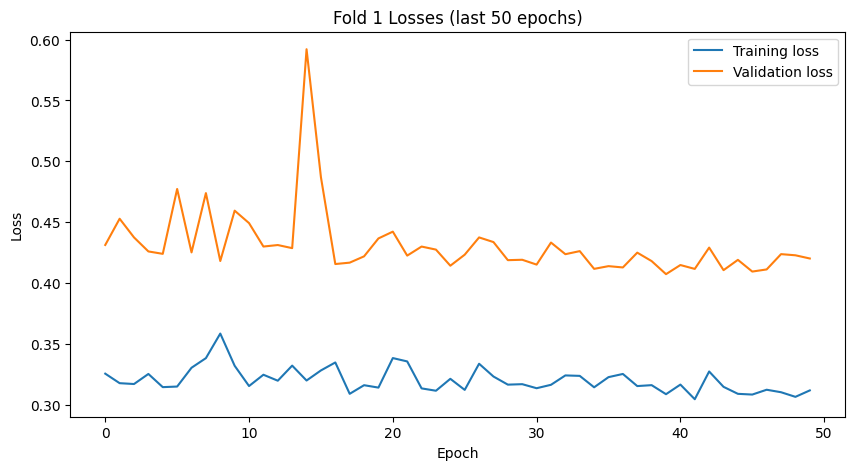

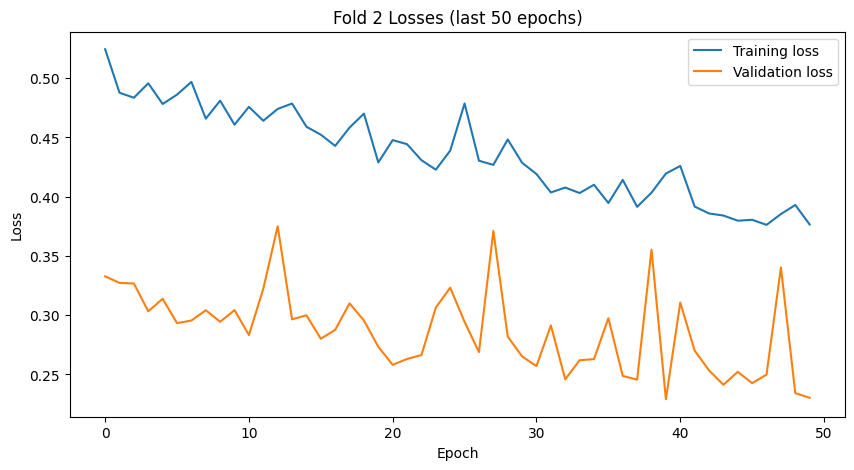

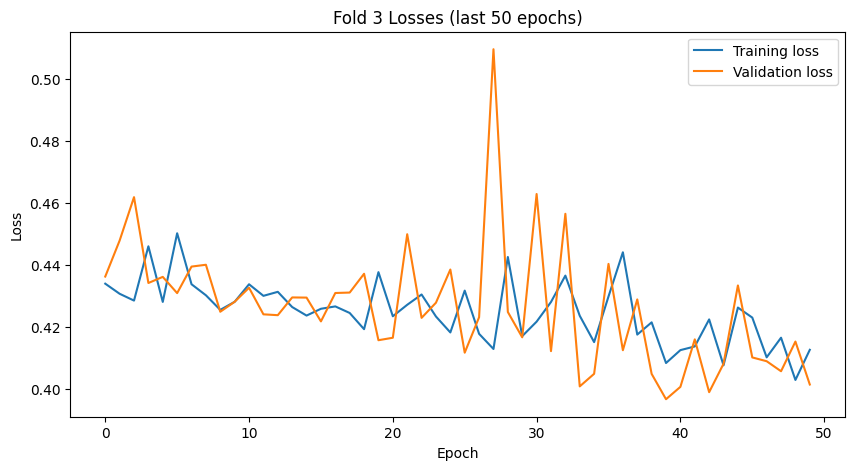

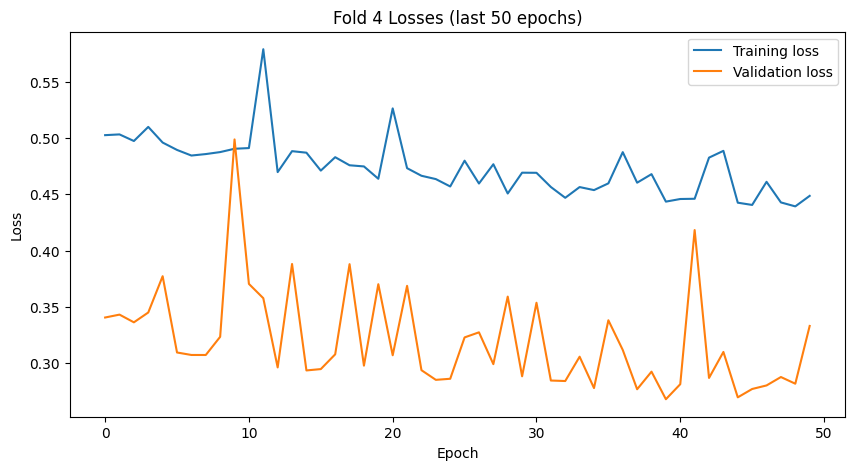

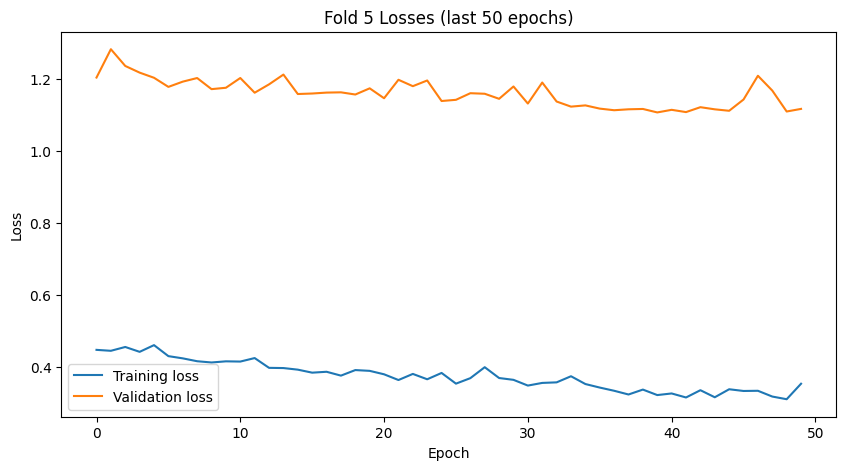

In [15]:
# function to plot the last n epochs train and test losses of each fold
def plot_last_n_epochs(train_los, val_los, n):
    for i in range(len(train_losses_all_folds)):
        train = train_los[i]
        val = val_los[i]
        
        plt.figure(figsize=(10, 5))
        plt.plot(train[-n:], label='Training loss')
        plt.plot(val[-n:], label='Validation loss')
        plt.title(f"Fold {i + 1} Losses (last {n} epochs)")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

plot_last_n_epochs(train_losses_all_folds, val_losses_all_folds, 50)

In [12]:
# Function to reset weights and biases
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# Apply the reset function to each layer
model.apply(reset_weights)

Sequential(
  (0): Linear(in_features=53, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)